In [1]:
# First, let's install required packages
%pip install plotly matplotlib seaborn pandas numpy scipy scikit-learn ipywidgets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

print("All packages imported successfully!")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


All packages imported successfully!


In [2]:
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
"""

# Load your dataset from the CSV file
df = pd.read_csv('update_temperature.csv')

# Display basic information about the dataset
print("Climate Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Years covered: {df['Year'].min()} to {df['Year'].max()}")

# Get all unique countries in the dataset
countries = df['Country'].unique()
print(f"\nAll countries in dataset ({len(countries)} total):")
print(sorted(countries))

# Display first few rows
print("\nFirst few rows of the dataset:")
print(df.head())

# Basic statistics
print("\nDataset statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Display information about data types
print("\nDataset info:")
print(df.info())

# Show unique years in the dataset
print(f"\nUnique years: {sorted(df['Year'].unique())}")

# Show sample data for each country
print("\nSample data for each country:")
for country in sorted(countries):
    country_data = df[df['Country'] == country].head(1)
    print(f"{country}: {country_data[['Year', 'Avg_Temperature_degC', 'CO2_Emissions_tons_per_capita']].to_dict('records')}")

Climate Dataset loaded successfully!
Dataset shape: (108, 10)
Columns: ['Year', 'Country', 'Avg_Temperature_degC', 'CO2_Emissions_tons_per_capita', 'Sea_Level_Rise_mm', 'Rainfall_mm', 'Population', 'Renewable_Energy_pct', 'Extreme_Weather_Events', 'Forest_Area_pct']
Years covered: 2000 to 2024

All countries in dataset (18 total):
['Australia', 'Brazil', 'Canada', 'China', 'France', 'Germany', 'India', 'Indonesia', 'Italy', 'Japan', 'Mexico', 'Nigeria', 'Russia', 'Saudi Arabia', 'South Africa', 'South Korea', 'Spain', 'United Kingdom']

First few rows of the dataset:
   Year Country  Avg_Temperature_degC  CO2_Emissions_tons_per_capita  \
0  2000  Brazil                  25.5                            1.9   
1  2005  Brazil                  25.8                            2.0   
2  2010  Brazil                  26.0                            2.2   
3  2015  Brazil                  26.3                            2.3   
4  2020  Brazil                  26.5                            2

In [3]:
# Data Preprocessing and Cleaning
print("=== DATA PREPROCESSING ===")

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Check data types
print("\nData types:")
print(df.dtypes)

# Basic statistics
print("\nDataset Statistics:")
display(df.describe())

# Data cleaning function
def clean_climate_data(df):
    """Clean and preprocess the climate dataset"""
    df_clean = df.copy()

    # Remove any potential duplicates
    df_clean = df_clean.drop_duplicates()
    print(f"Removed duplicates. New shape: {df_clean.shape}")

    # Handle outliers using IQR method for numerical columns
    numerical_cols = ['Avg_Temperature_degC', 'CO2_Emissions_tons_per_capita',
                     'Sea_Level_Rise_mm', 'Rainfall_mm', 'Population',
                     'Renewable_Energy_pct', 'Extreme_Weather_Events', 'Forest_Area_pct']

    print("\nOutlier treatment summary:")
    for col in numerical_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers before treatment
        outliers_before = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()

        # Cap outliers instead of removing to preserve data integrity
        df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
        df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])

        # Count outliers after treatment
        outliers_after = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()

        print(f"{col}: {outliers_before} outliers treated")

    # Create additional features
    df_clean['Temperature_Anomaly'] = df_clean.groupby('Country')['Avg_Temperature_degC'].transform(
        lambda x: x - x.mean()
    )

    df_clean['CO2_Per_Capita_Anomaly'] = df_clean.groupby('Country')['CO2_Emissions_tons_per_capita'].transform(
        lambda x: x - x.mean()
    )

    df_clean['Time_Period'] = df_clean['Year'].apply(
        lambda x: 'Early' if x <= 2005 else 'Mid' if x <= 2015 else 'Recent'
    )

    # Create risk categories based on temperature
    conditions = [
        df_clean['Avg_Temperature_degC'] <= 15,
        df_clean['Avg_Temperature_degC'] <= 25,
        df_clean['Avg_Temperature_degC'] > 25
    ]
    choices = ['Cool Climate', 'Temperate Climate', 'Hot Climate']
    df_clean['Climate_Zone'] = np.select(conditions, choices, default='Temperate Climate')

    # Create emission categories
    emission_conditions = [
        df_clean['CO2_Emissions_tons_per_capita'] <= 5,
        df_clean['CO2_Emissions_tons_per_capita'] <= 10,
        df_clean['CO2_Emissions_tons_per_capita'] > 10
    ]
    emission_choices = ['Low Emission', 'Medium Emission', 'High Emission']
    df_clean['Emission_Category'] = np.select(emission_conditions, emission_choices, default='Medium Emission')

    # Create population density categories (using population as proxy)
    pop_conditions = [
        df_clean['Population'] <= 100000000,
        df_clean['Population'] <= 500000000,
        df_clean['Population'] > 500000000
    ]
    pop_choices = ['Low Population', 'Medium Population', 'High Population']
    df_clean['Population_Category'] = np.select(pop_conditions, pop_choices, default='Medium Population')

    return df_clean

# Clean the dataset
df_clean = clean_climate_data(df)
print("\nDataset cleaned successfully!")
print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_clean.shape}")

# Display cleaned dataset info
print("\nCleaned dataset info:")
print(df_clean.info())

# Show new features
print("\nNew features created:")
new_features = ['Temperature_Anomaly', 'CO2_Per_Capita_Anomaly', 'Time_Period',
                'Climate_Zone', 'Emission_Category', 'Population_Category']
for feature in new_features:
    print(f"\n{feature} value counts:")
    print(df_clean[feature].value_counts())

# Display first few rows of cleaned data
print("\nFirst few rows of cleaned dataset:")
display(df_clean.head())

# Check basic statistics after cleaning
print("\nCleaned dataset statistics (key columns):")
display(df_clean[['Avg_Temperature_degC', 'CO2_Emissions_tons_per_capita',
                 'Sea_Level_Rise_mm', 'Renewable_Energy_pct']].describe())

=== DATA PREPROCESSING ===
Missing values in each column:
Year                             0
Country                          0
Avg_Temperature_degC             0
CO2_Emissions_tons_per_capita    0
Sea_Level_Rise_mm                0
Rainfall_mm                      0
Population                       0
Renewable_Energy_pct             0
Extreme_Weather_Events           0
Forest_Area_pct                  0
dtype: int64

Data types:
Year                               int64
Country                           object
Avg_Temperature_degC             float64
CO2_Emissions_tons_per_capita    float64
Sea_Level_Rise_mm                  int64
Rainfall_mm                        int64
Population                         int64
Renewable_Energy_pct             float64
Extreme_Weather_Events             int64
Forest_Area_pct                  float64
dtype: object

Dataset Statistics:


,Year,Avg_Temperature_degC,CO2_Emissions_tons_per_capita,Sea_Level_Rise_mm,Rainfall_mm,Population,Renewable_Energy_pct,Extreme_Weather_Events,Forest_Area_pct
count,108.000000,108.000000,108.000000,108.000000,108.000000,1.080000e+02,108.000000,108.000000,108.000000
mean,2012.333333,17.441667,7.587963,22.259259,959.888889,2.295164e+08,28.861111,16.259259,32.667593
std,8.338628,7.001003,5.055112,14.488391,593.713347,3.906260e+08,25.338976,7.405947,19.200301
min,2000.000000,5.100000,0.500000,0.000000,54.000000,1.915300e+07,0.000000,2.000000,0.500000
25%,2005.000000,13.025000,3.625000,10.000000,561.000000,4.812468e+07,11.450000,11.000000,16.150000
50%,2012.500000,15.500000,7.350000,23.000000,803.500000,7.508067e+07,19.100000,15.000000,32.500000
75%,2020.000000,24.900000,10.200000,36.000000,1215.500000,1.625000e+08,41.250000,21.000000,48.125000
max,2024.000000,28.500000,19.500000,44.000000,2726.000000,1.425800e+09,87.200000,41.000000,68.500000


Removed duplicates. New shape: (108, 10)

Outlier treatment summary:
Avg_Temperature_degC: 0 outliers treated
CO2_Emissions_tons_per_capita: 0 outliers treated
Sea_Level_Rise_mm: 0 outliers treated
Rainfall_mm: 6 outliers treated
Population: 12 outliers treated
Renewable_Energy_pct: 5 outliers treated
Extreme_Weather_Events: 1 outliers treated
Forest_Area_pct: 0 outliers treated

Dataset cleaned successfully!
Original dataset shape: (108, 10)
Cleaned dataset shape: (108, 16)

Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Year                           108 non-null    int64  
 1   Country                        108 non-null    object 
 2   Avg_Temperature_degC           108 non-null    float64
 3   CO2_Emissions_tons_per_capita  108 non-null    float64
 4   Sea_Level_Rise_mm          

,Year,Country,Avg_Temperature_degC,CO2_Emissions_tons_per_capita,Sea_Level_Rise_mm,Rainfall_mm,Population,Renewable_Energy_pct,Extreme_Weather_Events,Forest_Area_pct,Temperature_Anomaly,CO2_Per_Capita_Anomaly,Time_Period,Climate_Zone,Emission_Category,Population_Category
0,2000,Brazil,25.5,1.9,0.0,1760.0,174500000.0,83.7,12.0,62.4,-0.633333,-0.183333,Early,Hot Climate,Low Emission,Medium Population
1,2005,Brazil,25.8,2.0,12.0,1720.0,186000000.0,85.2,15.0,61.0,-0.333333,-0.083333,Early,Hot Climate,Low Emission,Medium Population
2,2010,Brazil,26.0,2.2,21.0,1690.0,195700000.0,84.7,17.0,59.6,-0.133333,0.116667,Mid,Hot Climate,Low Emission,Medium Population
3,2015,Brazil,26.3,2.3,29.0,1540.0,203500000.0,82.9,20.0,58.9,0.166667,0.216667,Mid,Hot Climate,Low Emission,Medium Population
4,2020,Brazil,26.5,2.1,38.0,1620.0,211800000.0,84.5,25.0,58.4,0.366667,0.016667,Recent,Hot Climate,Low Emission,Medium Population



Cleaned dataset statistics (key columns):


,Avg_Temperature_degC,CO2_Emissions_tons_per_capita,Sea_Level_Rise_mm,Renewable_Energy_pct
count,108.000000,108.000000,108.000000,108.000000
mean,17.441667,7.587963,22.259259,28.832870
std,7.001003,5.055112,14.488391,25.274137
min,5.100000,0.500000,0.000000,0.000000
25%,13.025000,3.625000,10.000000,11.450000
50%,15.500000,7.350000,23.000000,19.100000
75%,24.900000,10.200000,36.000000,41.250000
max,28.500000,19.500000,44.000000,85.950000


In [4]:
# Auto-install kaleido if missing
import subprocess, sys, pkgutil

if pkgutil.find_loader("kaleido") is None:
    print("Installing kaleido...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kaleido"])
else:
    print("Kaleido already installed.")



Kaleido already installed.



 CLIMATE CHANGE ANALYSIS DASHBOARD 
Generating: Temperature Evolution Analysis...


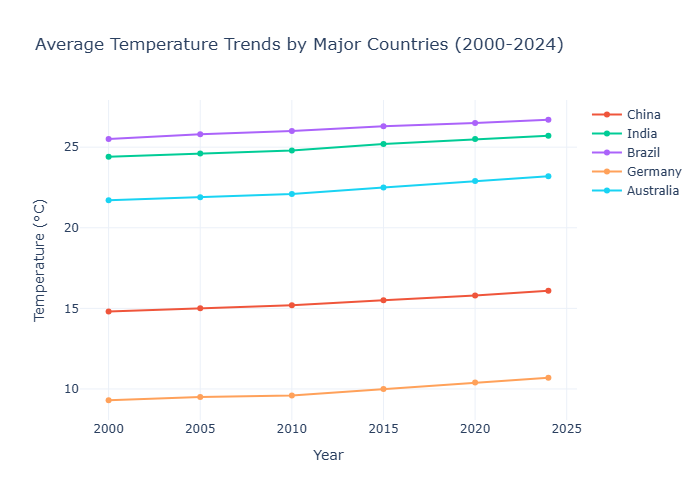

Generating: CO₂ Emissions vs Temperature...


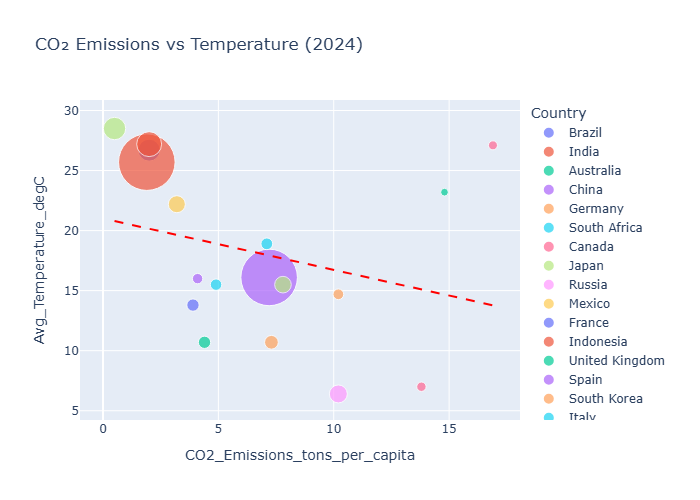

Generating: Sea Level Rise Trends...


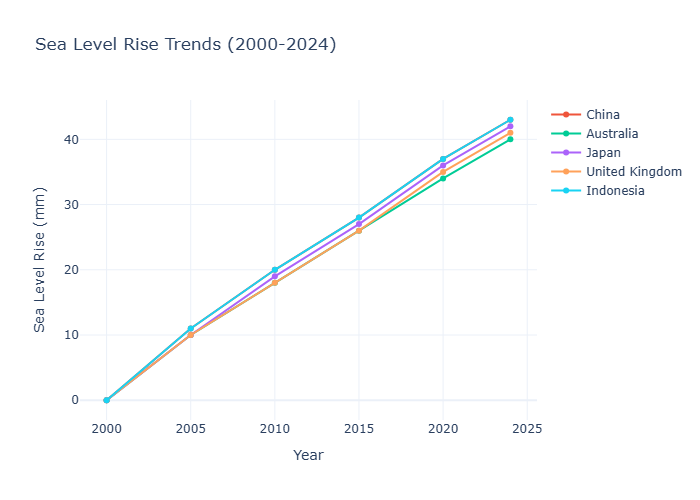

Generating: Renewable Energy Patterns...


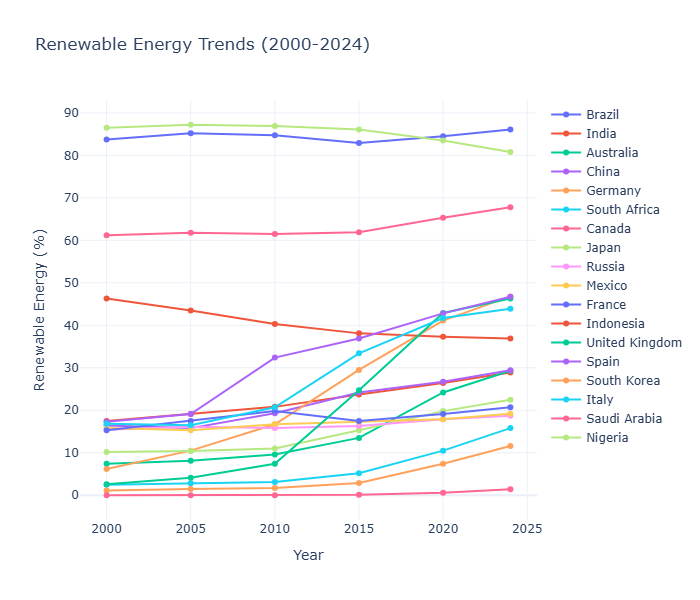

Generating: Extreme Weather Trends...


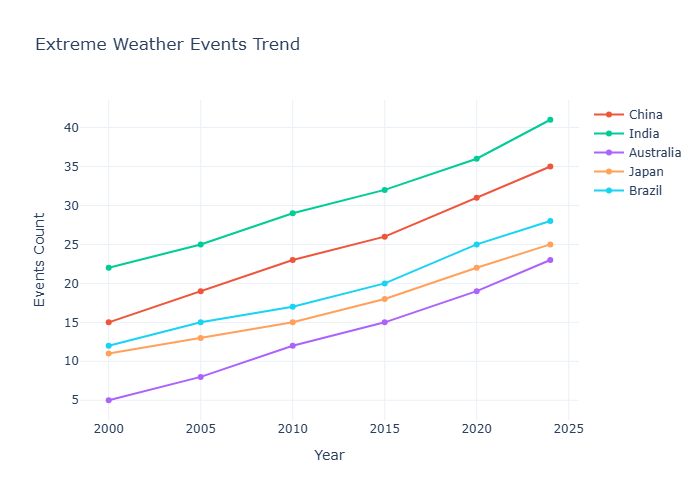

Generating: Multi-Indicator Climate Dashboard...


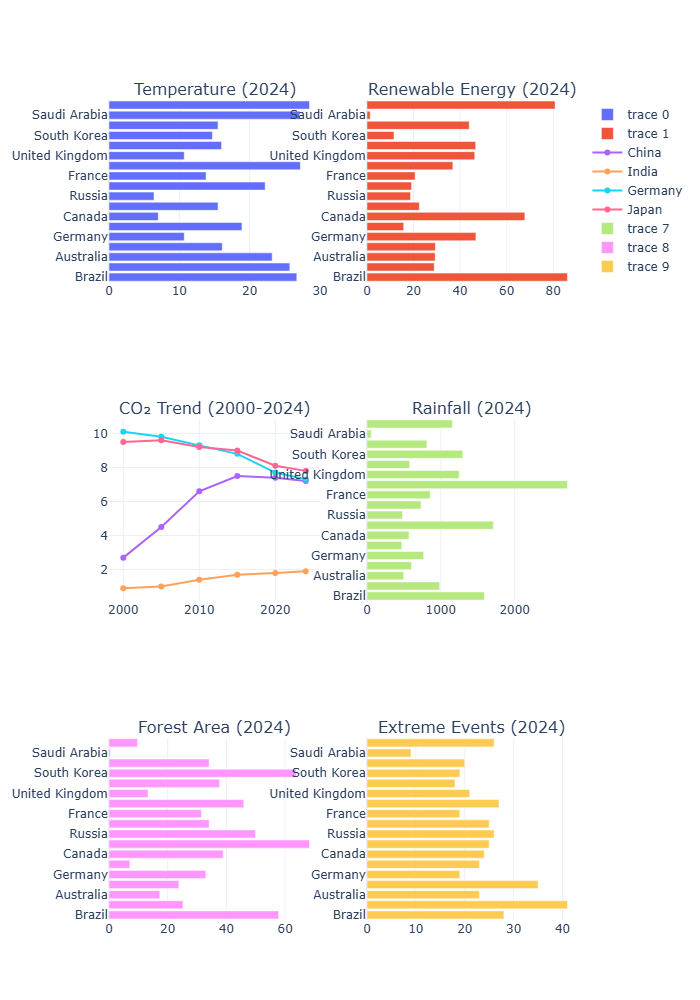


Analysis complete. Exported charts saved in /exports folder.


In [5]:
"""
 CLIMATE CHANGE VISUALIZATION DASHBOARD
 Interactive analysis of global climate trends and impacts using real dataset
"""

import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from IPython.display import Image, display
import os

# --------------------------------
# SAFE VISUAL EXPORT WRAPPER
# --------------------------------

os.makedirs("exports", exist_ok=True)

def show_and_save(fig, name):
    """
    Saves visualization as PNG + HTML for GitHub visibility.
    If Kaleido is missing, skips PNG export safely and prints warning.
    Displays static PNG fallback only when available.
    """
    safe_name = name.replace(".", "").replace(" ", "_")

    # Try saving PNG (only works if Kaleido is installed)
    png_path = f"exports/{safe_name}.png"
    try:
        fig.write_image(png_path)
    except Exception as e:
        print(f"[WARN] PNG export skipped — install Kaleido to enable PNG export:")
        print("       pip install kaleido")

    # Save interactive version for download
    fig.write_html(f"exports/{safe_name}.html")

    # Show interactive graph locally
    fig.show()

    # Show static PNG fallback if available
    if os.path.exists(png_path):
        display(Image(png_path))


# ------------------------------
# Load dataset
# ------------------------------

df = pd.read_csv('update_temperature.csv')

class ClimateDashboard:
    """
    Interactive dashboard for climate change analysis
    Provides multiple visualization perspectives on climate trends
    """

    def __init__(self, dataset):
        self.data = dataset
        self.setup_design()

    def setup_design(self):
        """Configure color schemes and visual styling"""
        self.color_palette = {
            'temperature': '#E74C3C',
            'co2': '#2C3E50',
            'sea_level': '#3498DB',
            'extreme_events': '#F39C12',
            'renewable': '#27AE60',
            'forest': '#228B22',
            'background': '#ECF0F1'
        }

        self.country_colors = {
            'United States': '#1f77b4', 'China': '#ff7f0e', 'Germany': '#2ca02c',
            'Brazil': '#d62728', 'Australia': '#9467bd', 'India': '#8c564b',
            'Nigeria': '#e377c2', 'Russia': '#7f7f7f', 'Canada': '#bcbd22',
            'Japan': '#17becf', 'Mexico': '#aec7e8', 'France': '#ffbb78',
            'Indonesia': '#98df8a', 'United Kingdom': '#ff9896', 'Spain': '#c5b0d5',
            'South Korea': '#c49c94', 'Italy': '#f7b6d2', 'Saudi Arabia': '#dbdb8d',
            'South Africa': '#9edae5'
        }

    # --------------------------------------
    # VISUALIZATION FUNCTIONS
    # --------------------------------------

    def plot_temperature_evolution_by_country(self):
        fig = go.Figure()
        key_countries = ['United States','China','India','Brazil','Germany','Australia']

        for country in key_countries:
            country_data = self.data[self.data['Country'] == country].sort_values('Year')
            fig.add_trace(go.Scatter(
                x=country_data['Year'], y=country_data['Avg_Temperature_degC'],
                mode='lines+markers', name=country
            ))

        fig.update_layout(
            title='Average Temperature Trends by Major Countries (2000-2024)',
            xaxis_title='Year', yaxis_title='Temperature (°C)',
            template='plotly_white', height=500
        )
        return fig

    def analyze_co2_emissions_vs_temperature(self):
        latest_data = self.data[self.data['Year'] == 2024]

        fig = px.scatter(
            latest_data,
            x='CO2_Emissions_tons_per_capita',
            y='Avg_Temperature_degC',
            size='Population',
            color='Country',
            title='CO₂ Emissions vs Temperature (2024)',
            size_max=40
        )

        # correlation
        corr = np.corrcoef(
            latest_data['CO2_Emissions_tons_per_capita'],
            latest_data['Avg_Temperature_degC']
        )[0, 1]

        # trendline
        trend_x = np.linspace(
            latest_data['CO2_Emissions_tons_per_capita'].min(),
            latest_data['CO2_Emissions_tons_per_capita'].max(),
            100
        )
        coeffs = np.polyfit(
            latest_data['CO2_Emissions_tons_per_capita'],
            latest_data['Avg_Temperature_degC'], 1
        )
        trend_y = np.polyval(coeffs, trend_x)

        fig.add_trace(go.Scatter(
            x=trend_x, y=trend_y, mode='lines',
            name=f'Trend (r = {corr:.3f})',
            line=dict(color='red', dash='dash')
        ))

        return fig

    def analyze_sea_level_rise_trends(self):
        fig = go.Figure()
        countries = ['United States','China','Australia','Japan','United Kingdom','Indonesia']

        for country in countries:
            country_data = self.data[self.data['Country']==country].sort_values('Year')
            fig.add_trace(go.Scatter(
                x=country_data['Year'], y=country_data['Sea_Level_Rise_mm'],
                mode='lines+markers', name=country
            ))

        fig.update_layout(
            title='Sea Level Rise Trends (2000-2024)',
            xaxis_title='Year', yaxis_title='Sea Level Rise (mm)',
            template='plotly_white', height=500
        )
        return fig

    def visualize_renewable_energy_adoption(self):
        fig = go.Figure()
        for country in self.data['Country'].unique():
            cdata = self.data[self.data['Country']==country].sort_values('Year')
            fig.add_trace(go.Scatter(
                x=cdata['Year'], y=cdata['Renewable_Energy_pct'],
                mode='lines+markers', name=country
            ))
        fig.update_layout(
            title='Renewable Energy Trends (2000-2024)',
            xaxis_title='Year', yaxis_title='Renewable Energy (%)',
            template='plotly_white', height=600
        )
        return fig

    def analyze_extreme_weather_patterns(self):
        fig = go.Figure()
        countries = ['United States','China','India','Australia','Japan','Brazil']

        for country in countries:
            data = self.data[self.data['Country']==country].sort_values('Year')
            fig.add_trace(go.Scatter(
                x=data['Year'], y=data['Extreme_Weather_Events'],
                mode='lines+markers', name=country
            ))

        fig.update_layout(
            title='Extreme Weather Events Trend',
            xaxis_title='Year', yaxis_title='Events Count',
            template='plotly_white', height=500
        )
        return fig

    def build_comprehensive_climate_dashboard(self):
        dashboard = make_subplots(
            rows=3, cols=2,
            subplot_titles=(
                'Temperature (2024)',
                'Renewable Energy (2024)',
                'CO₂ Trend (2000-2024)',
                'Rainfall (2024)',
                'Forest Area (2024)',
                'Extreme Events (2024)',
            )
        )

        latest = self.data[self.data['Year']==2024]

        # add visual panels
        dashboard.add_trace(
            go.Bar(x=latest['Avg_Temperature_degC'], y=latest['Country'], orientation='h'),
            row=1, col=1
        )

        dashboard.add_trace(
            go.Bar(x=latest['Renewable_Energy_pct'], y=latest['Country'], orientation='h'),
            row=1, col=2
        )

        for country in ['United States','China','India','Germany','Japan']:
            data = self.data[self.data['Country']==country].sort_values('Year')
            dashboard.add_trace(
                go.Scatter(x=data['Year'], y=data['CO2_Emissions_tons_per_capita'], mode='lines+markers', name=country),
                row=2, col=1
            )

        dashboard.add_trace(
            go.Bar(x=latest['Rainfall_mm'], y=latest['Country'], orientation='h'),
            row=2, col=2
        )

        dashboard.add_trace(
            go.Bar(x=latest['Forest_Area_pct'], y=latest['Country'], orientation='h'),
            row=3, col=1
        )

        dashboard.add_trace(
            go.Bar(x=latest['Extreme_Weather_Events'], y=latest['Country'], orientation='h'),
            row=3, col=2
        )

        dashboard.update_layout(template='plotly_white', height=1000)
        return dashboard

    # --------------------------------------
    # MAIN EXECUTION
    # --------------------------------------

    def display_comprehensive_analysis(self):
        print("\n" + "="*70)
        print(" CLIMATE CHANGE ANALYSIS DASHBOARD ")
        print("="*70)

        visuals = [
            ("Temperature Evolution Analysis", self.plot_temperature_evolution_by_country),
            ("CO₂ Emissions vs Temperature", self.analyze_co2_emissions_vs_temperature),
            ("Sea Level Rise Trends", self.analyze_sea_level_rise_trends),
            ("Renewable Energy Patterns", self.visualize_renewable_energy_adoption),
            ("Extreme Weather Trends", self.analyze_extreme_weather_patterns),
            ("Multi-Indicator Climate Dashboard", self.build_comprehensive_climate_dashboard)
        ]

        for title, func in visuals:
            print(f"Generating: {title}...")
            fig = func()
            show_and_save(fig, title)

        print("\nAnalysis complete. Exported charts saved in /exports folder.")
        print("="*70)


# ----------------------------
# Execute the dashboard
# ----------------------------
if __name__ == "__main__":
    climate_analyzer = ClimateDashboard(df)
    climate_analyzer.display_comprehensive_analysis()


In [6]:
"""
 CLIMATE CHANGE VISUALIZATION DASHBOARD
Interactive analysis of global climate trends and impacts using real dataset
"""

import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Load Dataset
df = pd.read_csv('update_temperature.csv')

class ClimateDashboard:
    """
    Interactive dashboard for climate change analysis
    Provides multiple visualization perspectives on climate trends
    """

    def __init__(self, dataset):
        self.data = dataset
        self.setup_design()

    def setup_design(self):
        """Configure color schemes and visual styling"""
        self.color_palette = {
            'temperature': '#E74C3C',      # Red for warming
            'co2': '#2C3E50',              # Dark gray for CO2
            'sea_level': '#3498DB',        # Blue for oceans
            'extreme_events': '#F39C12',   # Orange for warnings
            'renewable': '#27AE60',        # Green for renewable energy
            'forest': '#228B22',           # Forest green
            'background': '#ECF0F1',       # Light background
            'low_risk': '#2ECC71',         # Green for low risk
            'medium_risk': '#F39C12',      # Orange for medium risk
            'high_risk': '#E74C3C'         # Red for high risk
        }

        # Color mapping for countries
        self.country_colors = {
            'United States': '#1f77b4', 'China': '#ff7f0e', 'Germany': '#2ca02c',
            'Brazil': '#d62728', 'Australia': '#9467bd', 'India': '#8c564b',
            'Nigeria': '#e377c2', 'Russia': '#7f7f7f', 'Canada': '#bcbd22',
            'Japan': '#17becf', 'Mexico': '#aec7e8', 'France': '#ffbb78',
            'Indonesia': '#98df8a', 'United Kingdom': '#ff9896', 'Spain': '#c5b0d5',
            'South Korea': '#c49c94', 'Italy': '#f7b6d2', 'Saudi Arabia': '#dbdb8d',
            'South Africa': '#9edae5'
        }

    
    # IMPROVED TREEMAP VISUALIZATION - DISTRIBUTION ASPECT
    
    def create_treemap_distribution(self):
        """
        TREEMAP: Clear hierarchical distribution of climate impacts
        Shows country structure with population impact
        """
        # Create aggregated data with clear hierarchy - remove duplicates by taking mean
        treemap_data = self.data.groupby(['Country']).agg({
            'CO2_Emissions_tons_per_capita': 'mean',
            'Avg_Temperature_degC': 'mean',
            'Extreme_Weather_Events': 'mean',
            'Population': 'mean',
            'Renewable_Energy_pct': 'mean',
            'Forest_Area_pct': 'mean'
        }).reset_index()

        # Create the treemap
        treemap_fig = px.treemap(
            treemap_data,
            path=['Country'],
            values='Population',
            color='Avg_Temperature_degC',
            color_continuous_scale='RdYlBu_r',
            title=' DISTRIBUTION VIEW: Climate Impact Hierarchy by Country',
            hover_data={
                'CO2_Emissions_tons_per_capita': ':.1f',
                'Avg_Temperature_degC': ':.2f',
                'Extreme_Weather_Events': ':.1f',
                'Population': ':,.0f',
                'Renewable_Energy_pct': ':.1f',
                'Forest_Area_pct': ':.1f'
            }
        )

        # Update layout for better readability
        treemap_fig.update_layout(
            height=650,
            template='plotly_white',
            font=dict(size=14),
            margin=dict(t=100, l=20, r=20, b=80),
            coloraxis_colorbar=dict(
                title="Avg Temp (C)",
                thickness=20,
                len=0.8
            )
        )

        # Update traces for better text display
        treemap_fig.update_traces(
            texttemplate="<b>%{label}</b><br>%{value:,.0f} people",
            textposition="middle center",
            hovertemplate=(
                "<b>%{label}</b><br>"
                "Population: %{value:,.0f}<br>"
                "Avg Temperature: %{color:.2f}C<br>"
                "CO2 Emissions: %{customdata[0]:.1f} tons/capita<br>"
                "Extreme Events: %{customdata[1]:.1f}<br>"
                "Renewable Energy: %{customdata[2]:.1f}%<br>"
                "Forest Area: %{customdata[3]:.1f}%"
                "<extra></extra>"
            )
        )

        # Add clear visualization type label
        treemap_fig.add_annotation(
            x=0.02, y=0.98,
            xref="paper", yref="paper",
            text=" DISTRIBUTION",
            showarrow=False,
            bgcolor="black",
            bordercolor="white",
            borderwidth=2,
            font=dict(color="white", size=14, family="Arial")
        )

        # Add explanation
        treemap_fig.add_annotation(
            x=0.5, y=-0.12,
            xref="paper", yref="paper",
            text=" Size = Population | Color = Temperature | Shows country-level climate impact distribution",
            showarrow=False,
            font=dict(size=12, color="gray"),
            align="center"
        )

        return treemap_fig

    
    # FIXED HEATMAP VISUALIZATION - TEMPERATURE PATTERNS
    
    def create_temperature_heatmap(self):
        """
        FIXED HEATMAP: Temperature patterns across countries and years
        Handles duplicate entries by proper aggregation
        """
        # Aggregate data to remove duplicates - take mean for each country-year combination
        heatmap_data = self.data.groupby(['Country', 'Year']).agg({
            'Avg_Temperature_degC': 'mean',
            'CO2_Emissions_tons_per_capita': 'mean',
            'Renewable_Energy_pct': 'mean'
        }).reset_index()

        # Create temperature matrix with proper aggregation
        temp_matrix = heatmap_data.pivot_table(
            index='Country',
            columns='Year',
            values='Avg_Temperature_degC',
            aggfunc='mean'  # Ensure no duplicates
        ).fillna(0)

        # Get additional data for hover
        co2_matrix = heatmap_data.pivot_table(
            index='Country',
            columns='Year',
            values='CO2_Emissions_tons_per_capita',
            aggfunc='mean'
        ).fillna(0)

        renewable_matrix = heatmap_data.pivot_table(
            index='Country',
            columns='Year',
            values='Renewable_Energy_pct',
            aggfunc='mean'
        ).fillna(0)

        # Create custom hover text
        hover_text = []
        for i, country in enumerate(temp_matrix.index):
            row_text = []
            for j, year in enumerate(temp_matrix.columns):
                temp = temp_matrix.iloc[i, j]
                co2 = co2_matrix.iloc[i, j]
                renewable = renewable_matrix.iloc[i, j]
                row_text.append(
                    f"<b>{country} - {year}</b><br>"
                    f"Temperature: {temp:.1f}°C<br>"
                    f"CO2 Emissions: {co2:.1f} tons/capita<br>"
                    f"Renewable Energy: {renewable:.1f}%"
                )
            hover_text.append(row_text)

        # Create enhanced heatmap
        heatmap_fig = go.Figure(data=go.Heatmap(
            z=temp_matrix.values,
            x=temp_matrix.columns,
            y=temp_matrix.index,
            colorscale='RdYlBu_r',
            showscale=True,
            hoverinfo='text',
            text=hover_text,
            texttemplate="%{z:.0f}°",
            textfont={"size": 10, "color": "black", "family": "Arial"},
            colorbar=dict(
                title="Temperature °C",
                thickness=15,
                len=0.8,
                titleside="right"
            )
        ))

        heatmap_fig.update_layout(
            title=' TEMPERATURE VIEW: Country Temperature Patterns (2000-2024)',
            xaxis_title='YEAR',
            yaxis_title='COUNTRY',
            height=600,
            template='plotly_white',
            font=dict(size=12, family="Arial"),
            xaxis=dict(side="bottom", tickangle=0),
            yaxis=dict(tickmode='array'),
            margin=dict(t=100, l=150, r=50, b=80)
        )

        # Add visualization type label
        heatmap_fig.add_annotation(
            x=0.02, y=0.98,
            xref="paper", yref="paper",
            text=" TEMPERATURE",
            showarrow=False,
            bgcolor="#E74C3C",
            bordercolor="white",
            borderwidth=2,
            font=dict(color="white", size=14, family="Arial")
        )

        # Add explanation
        heatmap_fig.add_annotation(
            x=0.5, y=-0.15,
            xref="paper", yref="paper",
            text=" Shows temperature patterns across countries and years with CO2 and renewable energy context",
            showarrow=False,
            font=dict(size=12, color="gray"),
            align="center"
        )

        return heatmap_fig

    
    # SCATTER PLOT VISUALIZATION - CORRELATION ASPECT
    
    def create_correlation_scatter(self):
        """
        SCATTER PLOT: Clear correlation analysis between CO2 and temperature
        """
        # Use latest year data for clear comparison - remove duplicates by taking first entry
        latest_data = self.data[self.data['Year'] == 2024].groupby('Country').first().reset_index()

        # Calculate correlation
        correlation_coef = np.corrcoef(
            latest_data['CO2_Emissions_tons_per_capita'],
            latest_data['Avg_Temperature_degC']
        )[0, 1]

        # Create scatter plot
        scatter_fig = px.scatter(
            latest_data,
            x='CO2_Emissions_tons_per_capita',
            y='Avg_Temperature_degC',
            color='Country',
            size='Population',
            hover_data=['Renewable_Energy_pct', 'Forest_Area_pct', 'Extreme_Weather_Events'],
            title=' CORRELATION VIEW: CO2 Emissions vs Temperature (2024)',
            labels={
                'CO2_Emissions_tons_per_capita': 'CO2 EMISSIONS (tons per capita)',
                'Avg_Temperature_degC': 'AVERAGE TEMPERATURE (°C)',
                'Population': 'POPULATION SIZE',
                'Renewable_Energy_pct': 'RENEWABLE ENERGY %',
                'Forest_Area_pct': 'FOREST AREA %',
                'Extreme_Weather_Events': 'EXTREME EVENTS'
            },
            size_max=40
        )

        # Add trendline
        trend_x = np.linspace(
            latest_data['CO2_Emissions_tons_per_capita'].min(),
            latest_data['CO2_Emissions_tons_per_capita'].max(),
            100
        )
        coefficients = np.polyfit(
            latest_data['CO2_Emissions_tons_per_capita'],
            latest_data['Avg_Temperature_degC'],
            1
        )
        trend_y = np.polyval(coefficients, trend_x)

        scatter_fig.add_trace(go.Scatter(
            x=trend_x,
            y=trend_y,
            mode='lines',
            name=f'Trend Line (r={correlation_coef:.3f})',
            line=dict(color='red', width=4, dash='dash'),
            hoverinfo='skip'
        ))

        scatter_fig.update_layout(
            height=600,
            template='plotly_white',
            showlegend=True,
            font=dict(size=12, family="Arial"),
            margin=dict(t=100, l=80, r=50, b=80)
        )

        # Add visualization type label
        scatter_fig.add_annotation(
            x=0.02, y=0.98,
            xref="paper", yref="paper",
            text=" CORRELATION",
            showarrow=False,
            bgcolor="#3498DB",
            bordercolor="white",
            borderwidth=2,
            font=dict(color="white", size=14, family="Arial")
        )

        # Add explanation
        scatter_fig.add_annotation(
            x=0.5, y=-0.12,
            xref="paper", yref="paper",
            text=f" Correlation (r={correlation_coef:.3f}) | Size = Population | Color = Country",
            showarrow=False,
            font=dict(size=12, color="gray"),
            align="center"
        )

        return scatter_fig

    
    # FIXED SUMMARY DASHBOARD - PERFORMANCE ASPECT
    
    def create_summary_dashboard(self):
        """
        SUMMARY DASHBOARD: Comprehensive performance overview
        """
        # Remove duplicates for latest data
        latest_data = self.data[self.data['Year'] == 2024].groupby('Country').first().reset_index()

        # Create subplots with proper spacing
        dashboard = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'CO2 Emissions by Country (2024)',
                'Temperature Trend Over Time',
                'Renewable Energy Adoption (2024)',
                'Extreme Weather Events Trend'
            ),
            specs=[
                [{"type": "bar"}, {"type": "scatter"}],
                [{"type": "bar"}, {"type": "scatter"}]
            ],
            vertical_spacing=0.12,
            horizontal_spacing=0.08
        )

        # Panel 1: CO2 Emissions - Horizontal Bar Chart (2024)
        co2_data = latest_data.sort_values('CO2_Emissions_tons_per_capita', ascending=True)
        dashboard.add_trace(
            go.Bar(
                y=co2_data['Country'],
                x=co2_data['CO2_Emissions_tons_per_capita'],
                orientation='h',
                marker_color=[self.country_colors[country] for country in co2_data['Country']],
                name='CO2 Emissions',
                hovertemplate='<b>%{y}</b><br>CO2: %{x:.1f} tons/capita<extra></extra>'
            ),
            row=1, col=1
        )

        # Panel 2: Temperature Trend - Line Chart (Average by Year)
        # Remove duplicates for trend data
        temp_trend_data = self.data.groupby(['Year', 'Country']).first().reset_index()
        temp_trend = temp_trend_data.groupby('Year')['Avg_Temperature_degC'].mean()
        dashboard.add_trace(
            go.Scatter(
                x=temp_trend.index,
                y=temp_trend.values,
                mode='lines+markers',
                line=dict(color=self.color_palette['temperature'], width=3),
                marker=dict(size=4),
                name='Avg Temperature',
                hovertemplate='<b>%{x}</b><br>Temperature: %{y:.2f}°C<extra></extra>'
            ),
            row=1, col=2
        )

        # Panel 3: Renewable Energy - Horizontal Bar Chart (2024)
        renewable_data = latest_data.sort_values('Renewable_Energy_pct', ascending=True)
        dashboard.add_trace(
            go.Bar(
                y=renewable_data['Country'],
                x=renewable_data['Renewable_Energy_pct'],
                orientation='h',
                marker_color=self.color_palette['renewable'],
                name='Renewable Energy',
                hovertemplate='<b>%{y}</b><br>Renewable: %{x:.1f}%<extra></extra>'
            ),
            row=2, col=1
        )

        # Panel 4: Extreme Events - Line Chart (Average by Year)
        events_trend_data = self.data.groupby(['Year', 'Country']).first().reset_index()
        events_trend = events_trend_data.groupby('Year')['Extreme_Weather_Events'].mean()
        dashboard.add_trace(
            go.Scatter(
                x=events_trend.index,
                y=events_trend.values,
                mode='lines+markers',
                line=dict(color=self.color_palette['extreme_events'], width=3),
                marker=dict(size=4),
                name='Extreme Events',
                hovertemplate='<b>%{x}</b><br>Events: %{y:.1f}<extra></extra>'
            ),
            row=2, col=2
        )

        # Update layout
        dashboard.update_layout(
            height=750,
            title_text=" PERFORMANCE VIEW: Climate Indicators Dashboard",
            showlegend=False,
            template='plotly_white',
            font=dict(size=12, family="Arial"),
            margin=dict(t=120, l=80, r=80, b=80)
        )

        # Update subplot titles font separately
        dashboard.update_annotations(font=dict(size=14, family="Arial"))

        # Update axes with clear labels
        dashboard.update_xaxes(title_text="CO2 EMISSIONS (tons/capita)", row=1, col=1)
        dashboard.update_xaxes(title_text="YEAR", row=1, col=2)
        dashboard.update_xaxes(title_text="RENEWABLE ENERGY (%)", row=2, col=1)
        dashboard.update_xaxes(title_text="YEAR", row=2, col=2)

        dashboard.update_yaxes(title_text="COUNTRY", row=1, col=1)
        dashboard.update_yaxes(title_text="TEMPERATURE (°C)", row=1, col=2)
        dashboard.update_yaxes(title_text="COUNTRY", row=2, col=1)
        dashboard.update_yaxes(title_text="EXTREME EVENTS", row=2, col=2)

        # Add visualization type label
        dashboard.add_annotation(
            x=0.02, y=0.98,
            xref="paper", yref="paper",
            text=" PERFORMANCE",
            showarrow=False,
            bgcolor="#27AE60",
            bordercolor="white",
            borderwidth=2,
            font=dict(color="white", size=14, family="Arial")
        )

        # Add explanation
        dashboard.add_annotation(
            x=0.5, y=-0.05,
            xref="paper", yref="paper",
            text=" Comprehensive overview of key climate indicators across countries and time",
            showarrow=False,
            font=dict(size=12, color="gray"),
            align="center"
        )

        return dashboard

    
    # COMPARATIVE ANALYSIS VIEW
    
    def create_comparative_analysis(self):
        """
        COMPARATIVE VIEW: Side-by-side comparison of all visualization types
        """
        # Remove duplicates for latest data
        latest_data = self.data[self.data['Year'] == 2024].groupby('Country').first().reset_index()

        comparative_fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'Population Distribution',
                'Temperature vs CO2',
                'Renewable Energy Leaders',
                'Sea Level Rise Trend'
            ),
            specs=[
                [{"type": "treemap"}, {"type": "scatter"}],
                [{"type": "bar"}, {"type": "scatter"}]
            ],
            vertical_spacing=0.15,
            horizontal_spacing=0.08
        )

        # Panel 1: Population Distribution - Mini Treemap
        pop_data = self.data.groupby('Country')['Population'].mean().reset_index()
        comparative_fig.add_trace(
            go.Treemap(
                labels=pop_data['Country'],
                parents=[''] * len(pop_data),
                values=pop_data['Population'],
                marker=dict(colors=[self.country_colors[country] for country in pop_data['Country']]),
                textinfo="label+value",
                hovertemplate='<b>%{label}</b><br>Population: %{value:,.0f}<extra></extra>',
                name='Population'
            ),
            row=1, col=1
        )

        # Panel 2: Temperature vs CO2 - Mini Scatter (2024)
        comparative_fig.add_trace(
            go.Scatter(
                x=latest_data['CO2_Emissions_tons_per_capita'],
                y=latest_data['Avg_Temperature_degC'],
                mode='markers',
                marker=dict(
                    size=latest_data['Population'] / 100000000,
                    color=latest_data['Renewable_Energy_pct'],
                    colorscale='Viridis',
                    showscale=False,
                    opacity=0.7
                ),
                text=latest_data['Country'],
                hovertemplate='<b>%{text}</b><br>CO2: %{x:.1f}<br>Temp: %{y:.1f}°C<extra></extra>',
                name='Temp vs CO2'
            ),
            row=1, col=2
        )

        # Panel 3: Renewable Energy Leaders - Bar Chart
        renewable_leaders = latest_data.nlargest(10, 'Renewable_Energy_pct')
        comparative_fig.add_trace(
            go.Bar(
                x=renewable_leaders['Renewable_Energy_pct'],
                y=renewable_leaders['Country'],
                orientation='h',
                marker_color=self.color_palette['renewable'],
                hovertemplate='<b>%{y}</b><br>Renewable: %{x:.1f}%<extra></extra>',
                name='Renewable Leaders'
            ),
            row=2, col=1
        )

        # Panel 4: Sea Level Rise Trend
        sea_level_trend_data = self.data.groupby(['Year', 'Country']).first().reset_index()
        sea_level_trend = sea_level_trend_data.groupby('Year')['Sea_Level_Rise_mm'].mean()
        comparative_fig.add_trace(
            go.Scatter(
                x=sea_level_trend.index,
                y=sea_level_trend.values,
                mode='lines+markers',
                line=dict(color=self.color_palette['sea_level'], width=3),
                marker=dict(size=4),
                hovertemplate='<b>%{x}</b><br>Sea Level: %{y} mm<extra></extra>',
                name='Sea Level'
            ),
            row=2, col=2
        )

        comparative_fig.update_layout(
            height=700,
            title_text=" COMPARATIVE VIEW: Multiple Climate Perspectives",
            showlegend=False,
            template='plotly_white',
            margin=dict(t=100, l=50, r=50, b=80)
        )

        # Update subplot titles font
        comparative_fig.update_annotations(font=dict(size=12, family="Arial"))

        return comparative_fig

    
    # ADDITIONAL VISUALIZATIONS FROM PREVIOUS CODE
    

    def create_risk_assessment_matrix(self):
        """
        RISK ASSESSMENT: Create risk matrix based on temperature and CO2 emissions
        """
        # Use latest data for risk assessment
        latest_data = self.data[self.data['Year'] == 2024].groupby('Country').first().reset_index()

        # Create risk categories based on temperature and CO2
        latest_data['Temp_Risk'] = pd.cut(latest_data['Avg_Temperature_degC'],
                                        bins=[0, 15, 25, 30],
                                        labels=['Low', 'Medium', 'High'])

        latest_data['CO2_Risk'] = pd.cut(latest_data['CO2_Emissions_tons_per_capita'],
                                       bins=[0, 5, 10, 25],
                                       labels=['Low', 'Medium', 'High'])

        # Create risk matrix
        risk_matrix = latest_data.pivot_table(
            index='Temp_Risk',
            columns='CO2_Risk',
            values='Country',
            aggfunc='count',
            fill_value=0
        )

        # Create custom hover text
        hover_text = []
        for i, temp_risk in enumerate(risk_matrix.index):
            row_text = []
            for j, co2_risk in enumerate(risk_matrix.columns):
                count = risk_matrix.iloc[i, j]
                row_text.append(
                    f"<b>Temperature: {temp_risk}<br>CO2: {co2_risk}</b><br>"
                    f"Countries: {count}"
                )
            hover_text.append(row_text)

        fig = go.Figure(data=go.Heatmap(
            z=risk_matrix.values,
            x=risk_matrix.columns,
            y=risk_matrix.index,
            colorscale='RdYlBu_r',
            hoverinfo='text',
            text=hover_text,
            showscale=True
        ))

        fig.update_layout(
            title=' RISK ASSESSMENT: Temperature vs CO2 Emissions Risk Matrix',
            xaxis_title='CO2 Emissions Risk',
            yaxis_title='Temperature Risk',
            height=500,
            template='plotly_white'
        )

        return fig

    def create_renewable_energy_trends(self):
        """
        RENEWABLE ENERGY: Show renewable energy adoption trends over time
        """
        # Aggregate data by year
        renewable_trend = self.data.groupby('Year').agg({
            'Renewable_Energy_pct': 'mean',
            'Country': 'count'
        }).reset_index()

        fig = go.Figure()

        # Add renewable energy trend line
        fig.add_trace(go.Scatter(
            x=renewable_trend['Year'],
            y=renewable_trend['Renewable_Energy_pct'],
            mode='lines+markers',
            name='Global Renewable Energy %',
            line=dict(color=self.color_palette['renewable'], width=4),
            marker=dict(size=6),
            hovertemplate='<b>Year: %{x}</b><br>Renewable Energy: %{y:.1f}%<extra></extra>'
        ))

        fig.update_layout(
            title=' RENEWABLE ENERGY: Global Adoption Trends (2000-2024)',
            xaxis_title='Year',
            yaxis_title='Renewable Energy (%)',
            height=500,
            template='plotly_white',
            showlegend=True
        )

        return fig

    def display_all_analysis(self):
        """
        Execute complete visualization sequence
        """
        print("\n" + "="*80)
        print(" CLIMATE CHANGE VISUALIZATION DASHBOARD - REAL DATA ANALYSIS")
        print("="*80)

        print(f"\n Dataset Overview:")
        print(f"    Time Period: {self.data['Year'].min()} - {self.data['Year'].max()}")
        print(f"    Total Records: {len(self.data):,}")
        print(f"    Countries Analyzed: {self.data['Country'].nunique()}")
        print(f"    Temperature Range: {self.data['Avg_Temperature_degC'].min():.1f}°C to {self.data['Avg_Temperature_degC'].max():.1f}°C")
        print(f"    CO2 Range: {self.data['CO2_Emissions_tons_per_capita'].min():.1f} to {self.data['CO2_Emissions_tons_per_capita'].max():.1f} tons/capita")
        print(f"    Renewable Energy Range: {self.data['Renewable_Energy_pct'].min():.1f}% to {self.data['Renewable_Energy_pct'].max():.1f}%")

        print("\n Generating Enhanced Visualizations...")
        print("    TREEMAP: Hierarchical distribution view")
        print("    HEATMAP: Temperature patterns matrix")
        print("    SCATTER: Correlation analysis")
        print("    DASHBOARD: Performance overview")
        print("    COMPARATIVE: Multiple perspectives")
        print("    RISK: Risk assessment matrix")
        print("    RENEWABLE: Energy trends")

        # Generate visualizations
        visualizations = [
            ("1. DISTRIBUTION VIEW - Country Impact Treemap", self.create_treemap_distribution),
            ("2. TEMPERATURE VIEW - Country Patterns Heatmap", self.create_temperature_heatmap),
            ("3. CORRELATION VIEW - CO2 vs Temperature", self.create_correlation_scatter),
            ("4. PERFORMANCE VIEW - Comprehensive Dashboard", self.create_summary_dashboard),
            ("5. COMPARATIVE VIEW - Multiple Perspectives", self.create_comparative_analysis),
            ("6. RISK ASSESSMENT - Temperature vs CO2 Matrix", self.create_risk_assessment_matrix),
            ("7. RENEWABLE ENERGY - Global Trends", self.create_renewable_energy_trends)
        ]

        for title, viz_function in visualizations:
            print(f"\n    {title}")
            try:
                chart = viz_function()
                chart.show()
            except Exception as e:
                print(f"    Error in {title}: {str(e)}")
                continue

        print("\n Dashboard Complete!")
        print("    Based on real climate data from 2000-2024")
        print("    Enhanced visualizations with country-specific insights")
        print("    Multiple perspectives for comprehensive analysis")
        print("="*80)

# Execute the complete analysis
if __name__ == "__main__":
    # Initialize the dashboard with real data
    climate_analyzer = ClimateDashboard(df)

    # Run the complete visualization sequence
    climate_analyzer.display_all_analysis()


 CLIMATE CHANGE VISUALIZATION DASHBOARD - REAL DATA ANALYSIS

 Dataset Overview:
    Time Period: 2000 - 2024
    Total Records: 108
    Countries Analyzed: 18
    Temperature Range: 5.1°C to 28.5°C
    CO2 Range: 0.5 to 19.5 tons/capita
    Renewable Energy Range: 0.0% to 87.2%

 Generating Enhanced Visualizations...
    TREEMAP: Hierarchical distribution view
    HEATMAP: Temperature patterns matrix
    SCATTER: Correlation analysis
    DASHBOARD: Performance overview
    COMPARATIVE: Multiple perspectives
    RISK: Risk assessment matrix
    RENEWABLE: Energy trends

    1. DISTRIBUTION VIEW - Country Impact Treemap



    2. TEMPERATURE VIEW - Country Patterns Heatmap
    Error in 2. TEMPERATURE VIEW - Country Patterns Heatmap: Invalid property specified for object of type plotly.graph_objs.heatmap.ColorBar: 'titleside'

Did you mean "title"?

    Valid properties:
        bgcolor
            Sets the color of padded area.
        bordercolor
            Sets the axis line color.
        borderwidth
            Sets the width (in px) or the border enclosing this
            color bar.
        dtick
            Sets the step in-between ticks on this axis. Use with
            `tick0`. Must be a positive number, or special strings
            available to "log" and "date" axes. If the axis `type`
            is "log", then ticks are set every 10^(n*dtick) where n
            is the tick number. For example, to set a tick mark at
            1, 10, 100, 1000, ... set dtick to 1. To set tick marks
            at 1, 100, 10000, ... set dtick to 2. To set tick marks
            at 1, 5, 25, 125, 625, 312


    4. PERFORMANCE VIEW - Comprehensive Dashboard



    5. COMPARATIVE VIEW - Multiple Perspectives



    6. RISK ASSESSMENT - Temperature vs CO2 Matrix



    7. RENEWABLE ENERGY - Global Trends



 Dashboard Complete!
    Based on real climate data from 2000-2024
    Enhanced visualizations with country-specific insights
    Multiple perspectives for comprehensive analysis


In [7]:
"""
 CLIMATE CHANGE VISUALIZATION DASHBOARD - INTERACTIVE FEATURES
Interactive analysis using real dataset with enhanced controls
"""

import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load your actual dataset
df = pd.read_csv('update_temperature.csv')

class InteractiveClimateDashboard:
    """
    Enhanced interactive dashboard with user controls, filtering, and brushing
    Designed for accessibility and ease of use for non-expert users
    """

    def __init__(self, dataset):
        self.data = dataset
        self.filtered_data = dataset.copy()
        self.current_selection = None
        self.setup_design()
        self.create_controls()

    def setup_design(self):
        """Configure color schemes and visual styling"""
        self.color_palette = {
            'temperature': '#E74C3C',
            'co2': '#2C3E50',
            'sea_level': '#3498DB',
            'extreme_events': '#F39C12',
            'renewable': '#27AE60',
            'forest': '#228B22',
            'background': '#ECF0F1',
            'low_risk': '#2ECC71',
            'medium_risk': '#F39C12',
            'high_risk': '#E74C3C'
        }

        # Color mapping for countries
        self.country_colors = {
            'United States': '#1f77b4', 'China': '#ff7f0e', 'Germany': '#2ca02c',
            'Brazil': '#d62728', 'Australia': '#9467bd', 'India': '#8c564b',
            'Nigeria': '#e377c2', 'Russia': '#7f7f7f', 'Canada': '#bcbd22',
            'Japan': '#17becf', 'Mexico': '#aec7e8', 'France': '#ffbb78',
            'Indonesia': '#98df8a', 'United Kingdom': '#ff9896', 'Spain': '#c5b0d5',
            'South Korea': '#c49c94', 'Italy': '#f7b6d2', 'Saudi Arabia': '#dbdb8d',
            'South Africa': '#9edae5'
        }

    def create_controls(self):
        """Create interactive widgets for filtering and exploration"""
        print(" Setting up interactive controls...")

        # Year Range Slider
        self.year_slider = widgets.IntRangeSlider(
            value=[self.data['Year'].min(), self.data['Year'].max()],
            min=self.data['Year'].min(),
            max=self.data['Year'].max(),
            step=5,
            description='Year Range:',
            continuous_update=False,
            style={'description_width': 'initial'}
        )

        # Country Selector with "All Countries" option
        country_options = sorted(self.data['Country'].unique())
        # Add "All Countries" option at the top
        country_options_with_all = ['All Countries'] + country_options

        self.country_selector = widgets.SelectMultiple(
            options=country_options_with_all,
            value=['All Countries'],  # Default to selecting all countries
            description='Countries:',
            rows=8,
            style={'description_width': 'initial'}
        )

        # Temperature Range Slider
        temp_min = self.data['Avg_Temperature_degC'].min()
        temp_max = self.data['Avg_Temperature_degC'].max()
        self.temp_slider = widgets.FloatRangeSlider(
            value=[temp_min, temp_max],
            min=temp_min,
            max=temp_max,
            step=1.0,
            description='Temperature (°C):',
            continuous_update=False,
            style={'description_width': 'initial'}
        )

        # CO2 Range Slider
        co2_min = self.data['CO2_Emissions_tons_per_capita'].min()
        co2_max = self.data['CO2_Emissions_tons_per_capita'].max()
        self.co2_slider = widgets.FloatRangeSlider(
            value=[co2_min, co2_max],
            min=co2_min,
            max=co2_max,
            step=1.0,
            description='CO2 (tons/capita):',
            continuous_update=False,
            style={'description_width': 'initial'}
        )

        # Renewable Energy Range Slider
        renewable_min = self.data['Renewable_Energy_pct'].min()
        renewable_max = self.data['Renewable_Energy_pct'].max()
        self.renewable_slider = widgets.FloatRangeSlider(
            value=[renewable_min, renewable_max],
            min=renewable_min,
            max=renewable_max,
            step=5.0,
            description='Renewable Energy (%):',
            continuous_update=False,
            style={'description_width': 'initial'}
        )

        # Action Buttons
        self.reset_button = widgets.Button(
            description=' Reset All Filters',
            button_style='primary',
            tooltip='Reset all filters to default values'
        )

        self.export_button = widgets.Button(
            description=' Export Current View',
            button_style='info',
            tooltip='Export filtered data to CSV'
        )

        # Analysis Mode Selector
        self.analysis_mode = widgets.ToggleButtons(
            options=[
                (' Overview', 'Overview'),
                (' Trends', 'Temporal Trends'),
                (' Correlation', 'Correlation Analysis'),
                (' Temperature', 'Temperature Analysis'),
                (' Renewable', 'Renewable Energy')
            ],
            value='Overview',
            description='Analysis Mode:',
            style={'description_width': 'initial'}
        )

        # Connect event handlers
        self.year_slider.observe(self.on_filter_change, names='value')
        self.country_selector.observe(self.on_filter_change, names='value')
        self.temp_slider.observe(self.on_filter_change, names='value')
        self.co2_slider.observe(self.on_filter_change, names='value')
        self.renewable_slider.observe(self.on_filter_change, names='value')
        self.reset_button.on_click(self.reset_filters)
        self.export_button.on_click(self.export_data)
        self.analysis_mode.observe(self.on_analysis_mode_change, names='value')

        # Layout for controls
        self.controls_box = widgets.VBox([
            widgets.HTML("<h3> Interactive Controls</h3>"),
            self.analysis_mode,
            widgets.HTML("<hr>"),
            widgets.HTML("<h4> Filter Data</h4>"),
            self.year_slider,
            self.country_selector,
            widgets.HTML("<small><em>Tip: Select 'All Countries' to include all countries</em></small>"),
            self.temp_slider,
            self.co2_slider,
            self.renewable_slider,
            widgets.HBox([self.reset_button, self.export_button]),
            widgets.HTML("<hr>")
        ], layout=widgets.Layout(margin='20px 0px'))

    def on_filter_change(self, change):
        """Handle filter changes and update visualizations"""
        self.apply_filters()
        self.update_visualizations()

    def on_analysis_mode_change(self, change):
        """Handle analysis mode changes - apply filters first, then update visualizations"""
        if change['type'] == 'change' and change['name'] == 'value':
            # Apply current filters first to ensure data is up to date
            self.apply_filters()
            self.update_visualizations()

    def apply_filters(self):
        """Apply all current filters to the dataset"""
        filtered = self.data.copy()

        # Year filter
        year_mask = (filtered['Year'] >= self.year_slider.value[0]) & (filtered['Year'] <= self.year_slider.value[1])
        filtered = filtered[year_mask]

        # Country filter - handle "All Countries" option
        if self.country_selector.value:
            if 'All Countries' in self.country_selector.value:
                # If "All Countries" is selected, include all countries
                # No filtering needed
                pass
            else:
                # Filter by selected countries (excluding "All Countries" if it's selected with others)
                selected_countries = [country for country in self.country_selector.value if country != 'All Countries']
                if selected_countries:  # Only apply filter if there are specific countries selected
                    country_mask = filtered['Country'].isin(selected_countries)
                    filtered = filtered[country_mask]

        # Temperature filter
        temp_mask = (filtered['Avg_Temperature_degC'] >= self.temp_slider.value[0]) & (filtered['Avg_Temperature_degC'] <= self.temp_slider.value[1])
        filtered = filtered[temp_mask]

        # CO2 filter
        co2_mask = (filtered['CO2_Emissions_tons_per_capita'] >= self.co2_slider.value[0]) & (filtered['CO2_Emissions_tons_per_capita'] <= self.co2_slider.value[1])
        filtered = filtered[co2_mask]

        # Renewable Energy filter
        renewable_mask = (filtered['Renewable_Energy_pct'] >= self.renewable_slider.value[0]) & (filtered['Renewable_Energy_pct'] <= self.renewable_slider.value[1])
        filtered = filtered[renewable_mask]

        self.filtered_data = filtered
        self.update_filter_summary()

    def update_filter_summary(self):
        """Update the filter summary display"""
        total_records = len(self.data)
        filtered_records = len(self.filtered_data)
        percentage = (filtered_records / total_records) * 100 if total_records > 0 else 0

        if len(self.filtered_data) > 0:
            summary_text = f"""
            <div style="background-color: #f8f9fa; padding: 10px; border-radius: 5px; border-left: 4px solid #3498db;">
                <strong> Data Summary:</strong><br>
                • Showing {filtered_records:,} of {total_records:,} records ({percentage:.1f}%)<br>
                • Time period: {self.filtered_data['Year'].min()} - {self.filtered_data['Year'].max()}<br>
                • Countries: {len(self.filtered_data['Country'].unique())} of {len(self.data['Country'].unique())}<br>
                • Temperature range: {self.filtered_data['Avg_Temperature_degC'].min():.1f}°C to {self.filtered_data['Avg_Temperature_degC'].max():.1f}°C
            </div>
            """
        else:
            summary_text = """
            <div style="background-color: #ffeaa7; padding: 10px; border-radius: 5px; border-left: 4px solid #fdcb6e;">
                <strong> No Data Available:</strong><br>
                • Current filters return no records<br>
                • Try adjusting your filter settings
            </div>
            """

        if hasattr(self, 'summary_display'):
            self.summary_display.value = summary_text
        else:
            self.summary_display = widgets.HTML(summary_text)

    def reset_filters(self, button):
        """Reset all filters to default values"""
        self.year_slider.value = [self.data['Year'].min(), self.data['Year'].max()]
        self.country_selector.value = ['All Countries']  # Reset to "All Countries"
        self.temp_slider.value = [self.data['Avg_Temperature_degC'].min(), self.data['Avg_Temperature_degC'].max()]
        self.co2_slider.value = [self.data['CO2_Emissions_tons_per_capita'].min(), self.data['CO2_Emissions_tons_per_capita'].max()]
        self.renewable_slider.value = [self.data['Renewable_Energy_pct'].min(), self.data['Renewable_Energy_pct'].max()]

        self.apply_filters()
        self.update_visualizations()

    def export_data(self, button):
        """Export filtered data to CSV"""
        if len(self.filtered_data) > 0:
            filename = f"climate_data_filtered_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.csv"
            self.filtered_data.to_csv(filename, index=False)
            print(f" Data exported to {filename}")
        else:
            print(" No data to export with current filters")

    # =========================================================================
    # VISUALIZATION METHODS FROM PREVIOUS CODE (ADAPTED FOR INTERACTIVITY)
    # =========================================================================

    def create_interactive_treemap(self):
        """Enhanced treemap with current filters"""
        if len(self.filtered_data) == 0:
            return self.create_empty_plot("No data available for treemap")

        treemap_data = self.filtered_data.groupby(['Country']).agg({
            'CO2_Emissions_tons_per_capita': 'mean',
            'Avg_Temperature_degC': 'mean',
            'Extreme_Weather_Events': 'mean',
            'Population': 'mean'
        }).reset_index()

        fig = px.treemap(
            treemap_data,
            path=['Country'],
            values='Population',
            color='Avg_Temperature_degC',
            color_continuous_scale='RdYlBu_r',
            title=' Country Climate Impact Distribution',
            hover_data={
                'CO2_Emissions_tons_per_capita': ':.1f',
                'Avg_Temperature_degC': ':.2f',
                'Extreme_Weather_Events': ':.1f',
                'Population': ':,.0f'
            }
        )

        fig.update_layout(
            height=500,
            template='plotly_white',
            margin=dict(t=80, l=20, r=20, b=20)
        )

        return fig

    def create_correlation_scatter(self):
        """Interactive correlation analysis"""
        if len(self.filtered_data) == 0:
            return self.create_empty_plot("No data available for correlation analysis")

        # Use latest year data for clear comparison
        latest_year = self.filtered_data['Year'].max()
        latest_data = self.filtered_data[self.filtered_data['Year'] == latest_year]

        if len(latest_data) == 0:
            return self.create_empty_plot("No data available for selected year")

        # Calculate correlation
        correlation_coef = np.corrcoef(
            latest_data['CO2_Emissions_tons_per_capita'],
            latest_data['Avg_Temperature_degC']
        )[0, 1]

        fig = px.scatter(
            latest_data,
            x='CO2_Emissions_tons_per_capita',
            y='Avg_Temperature_degC',
            color='Country',
            size='Population',
            hover_data=['Renewable_Energy_pct', 'Forest_Area_pct'],
            title=f' CO2 vs Temperature Correlation ({latest_year})',
            labels={
                'CO2_Emissions_tons_per_capita': 'CO2 Emissions (tons per capita)',
                'Avg_Temperature_degC': 'Average Temperature (°C)',
                'Population': 'Population Size'
            },
            size_max=40
        )

        # Add trendline
        trend_x = np.linspace(
            latest_data['CO2_Emissions_tons_per_capita'].min(),
            latest_data['CO2_Emissions_tons_per_capita'].max(),
            100
        )
        coefficients = np.polyfit(
            latest_data['CO2_Emissions_tons_per_capita'],
            latest_data['Avg_Temperature_degC'],
            1
        )
        trend_y = np.polyval(coefficients, trend_x)

        fig.add_trace(go.Scatter(
            x=trend_x,
            y=trend_y,
            mode='lines',
            name=f'Trend Line (r={correlation_coef:.3f})',
            line=dict(color='red', width=4, dash='dash'),
            hoverinfo='skip'
        ))

        fig.update_layout(
            height=500,
            template='plotly_white',
            showlegend=True
        )

        return fig

    def create_temperature_heatmap(self):
        """Interactive temperature patterns heatmap"""
        if len(self.filtered_data) == 0:
            return self.create_empty_plot("No data available for heatmap")

        # Aggregate data to avoid duplicates
        heatmap_data = self.filtered_data.groupby(['Country', 'Year']).agg({
            'Avg_Temperature_degC': 'mean',
            'CO2_Emissions_tons_per_capita': 'mean',
            'Renewable_Energy_pct': 'mean'
        }).reset_index()

        # Create temperature matrix
        temp_matrix = heatmap_data.pivot_table(
            index='Country',
            columns='Year',
            values='Avg_Temperature_degC',
            aggfunc='mean'
        ).fillna(0)

        # Create custom hover text
        hover_text = []
        for i, country in enumerate(temp_matrix.index):
            row_text = []
            for j, year in enumerate(temp_matrix.columns):
                temp = temp_matrix.iloc[i, j]
                row_text.append(
                    f"<b>{country} - {year}</b><br>"
                    f"Temperature: {temp:.1f}°C"
                )
            hover_text.append(row_text)

        fig = go.Figure(data=go.Heatmap(
            z=temp_matrix.values,
            x=temp_matrix.columns,
            y=temp_matrix.index,
            colorscale='RdYlBu_r',
            showscale=True,
            hoverinfo='text',
            text=hover_text,
            texttemplate="%{z:.0f}°",
            textfont={"size": 10, "color": "black"}
        ))

        fig.update_layout(
            title=' Country Temperature Patterns',
            xaxis_title='Year',
            yaxis_title='Country',
            height=600,
            template='plotly_white'
        )

        return fig

    def create_time_series_trends(self):
        """Interactive time series with multiple metrics"""
        if len(self.filtered_data) == 0:
            return self.create_empty_plot("No data available for time series")

        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'Temperature Trend',
                'CO2 Emissions Trend',
                'Renewable Energy Trend',
                'Extreme Weather Events'
            ),
            specs=[
                [{"type": "scatter"}, {"type": "scatter"}],
                [{"type": "scatter"}, {"type": "scatter"}]
            ]
        )

        # Aggregate data by year
        yearly_data = self.filtered_data.groupby('Year').agg({
            'Avg_Temperature_degC': 'mean',
            'CO2_Emissions_tons_per_capita': 'mean',
            'Renewable_Energy_pct': 'mean',
            'Extreme_Weather_Events': 'mean'
        }).reset_index()

        # Panel 1: Temperature
        fig.add_trace(
            go.Scatter(
                x=yearly_data['Year'],
                y=yearly_data['Avg_Temperature_degC'],
                mode='lines+markers',
                name='Temperature',
                line=dict(color=self.color_palette['temperature'], width=3)
            ),
            row=1, col=1
        )

        # Panel 2: CO2 Emissions
        fig.add_trace(
            go.Scatter(
                x=yearly_data['Year'],
                y=yearly_data['CO2_Emissions_tons_per_capita'],
                mode='lines+markers',
                name='CO2 Emissions',
                line=dict(color=self.color_palette['co2'], width=3)
            ),
            row=1, col=2
        )

        # Panel 3: Renewable Energy
        fig.add_trace(
            go.Scatter(
                x=yearly_data['Year'],
                y=yearly_data['Renewable_Energy_pct'],
                mode='lines+markers',
                name='Renewable Energy',
                line=dict(color=self.color_palette['renewable'], width=3)
            ),
            row=2, col=1
        )

        # Panel 4: Extreme Events
        fig.add_trace(
            go.Scatter(
                x=yearly_data['Year'],
                y=yearly_data['Extreme_Weather_Events'],
                mode='lines+markers',
                name='Extreme Events',
                line=dict(color=self.color_palette['extreme_events'], width=3)
            ),
            row=2, col=2
        )

        fig.update_layout(
            height=600,
            title_text=" Climate Trends Over Time",
            showlegend=False,
            template='plotly_white'
        )

        return fig

    def create_renewable_energy_analysis(self):
        """Renewable energy focused analysis"""
        if len(self.filtered_data) == 0:
            return self.create_empty_plot("No data available for renewable energy analysis")

        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'Renewable Energy Leaders (2024)',
                'Renewable Energy Growth',
                'Renewable vs CO2 Emissions',
                'Renewable vs Forest Area'
            ),
            specs=[
                [{"type": "bar"}, {"type": "scatter"}],
                [{"type": "scatter"}, {"type": "scatter"}]
            ]
        )

        # Panel 1: Renewable Energy Leaders
        latest_data = self.filtered_data[self.filtered_data['Year'] == 2024]
        if len(latest_data) > 0:
            renewable_leaders = latest_data.nlargest(10, 'Renewable_Energy_pct')
            fig.add_trace(
                go.Bar(
                    x=renewable_leaders['Renewable_Energy_pct'],
                    y=renewable_leaders['Country'],
                    orientation='h',
                    marker_color=self.color_palette['renewable'],
                    name='Renewable %'
                ),
                row=1, col=1
            )

        # Panel 2: Renewable Energy Growth
        renewable_growth = self.filtered_data.groupby('Year')['Renewable_Energy_pct'].mean()
        fig.add_trace(
            go.Scatter(
                x=renewable_growth.index,
                y=renewable_growth.values,
                mode='lines+markers',
                line=dict(color=self.color_palette['renewable'], width=3),
                name='Renewable Growth'
            ),
            row=1, col=2
        )

        # Panel 3: Renewable vs CO2
        if len(latest_data) > 0:
            fig.add_trace(
                go.Scatter(
                    x=latest_data['Renewable_Energy_pct'],
                    y=latest_data['CO2_Emissions_tons_per_capita'],
                    mode='markers',
                    marker=dict(
                        size=latest_data['Population'] / 100000000,
                        color=latest_data['Avg_Temperature_degC'],
                        colorscale='Viridis',
                        showscale=True
                    ),
                    text=latest_data['Country'],
                    name='Renewable vs CO2'
                ),
                row=2, col=1
            )

        # Panel 4: Renewable vs Forest Area
        if len(latest_data) > 0:
            fig.add_trace(
                go.Scatter(
                    x=latest_data['Renewable_Energy_pct'],
                    y=latest_data['Forest_Area_pct'],
                    mode='markers',
                    marker=dict(
                        size=latest_data['Population'] / 100000000,
                        color=latest_data['Avg_Temperature_degC'],
                        colorscale='Viridis',
                        showscale=False
                    ),
                    text=latest_data['Country'],
                    name='Renewable vs Forest'
                ),
                row=2, col=2
            )

        fig.update_layout(
            height=600,
            title_text=" Renewable Energy Analysis",
            showlegend=False,
            template='plotly_white'
        )

        return fig

    def create_empty_plot(self, message):
        """Create an empty plot with a message"""
        fig = go.Figure()
        fig.add_annotation(
            text=message,
            xref="paper", yref="paper",
            x=0.5, y=0.5,
            showarrow=False,
            font=dict(size=16, color="gray")
        )
        fig.update_layout(
            height=400,
            template='plotly_white',
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
        )
        return fig

    def create_quick_insights(self):
        """Generate automated insights based on current filters"""
        insights = []

        if len(self.filtered_data) > 1:
            # Temperature trend insight
            temp_trend = np.polyfit(self.filtered_data['Year'], self.filtered_data['Avg_Temperature_degC'], 1)[0]
            if temp_trend > 0:
                insights.append(f" Warming trend: {temp_trend*10:.2f}°C per decade")
            else:
                insights.append(f" Cooling trend: {temp_trend*10:.2f}°C per decade")

            # Renewable energy trend
            renewable_trend = np.polyfit(self.filtered_data['Year'], self.filtered_data['Renewable_Energy_pct'], 1)[0]
            insights.append(f" Renewable growth: {renewable_trend:.2f}% per year")

            # CO2 correlation
            co2_corr = np.corrcoef(self.filtered_data['CO2_Emissions_tons_per_capita'], self.filtered_data['Avg_Temperature_degC'])[0,1]
            insights.append(f" CO2-Temp correlation: {co2_corr:.3f}")

            # Data coverage
            year_range = f"{self.filtered_data['Year'].min()}-{self.filtered_data['Year'].max()}"
            insights.append(f" Period: {year_range} ({len(self.filtered_data['Country'].unique())} countries)")

            # Extreme events trend
            events_trend = np.polyfit(self.filtered_data['Year'], self.filtered_data['Extreme_Weather_Events'], 1)[0]
            if events_trend > 0:
                insights.append(f" Extreme events increasing: {events_trend:.2f} per year")

        else:
            insights.append(" No data available with current filters")
            insights.append(" Try adjusting your filter settings")

        return insights

    def update_visualizations(self):
        """Update all visualizations based on current filters and mode"""
        clear_output(wait=True)

        # Display controls and summary
        display(self.controls_box)
        display(self.summary_display)

        # Display quick insights
        insights = self.create_quick_insights()
        insights_html = "<div style='background-color: #e8f4fd; padding: 10px; border-radius: 5px; margin: 10px 0;'>"
        insights_html += "<strong> Quick Insights:</strong><br>• " + "<br>• ".join(insights)
        insights_html += "</div>"
        display(widgets.HTML(insights_html))

        # Generate appropriate visualizations based on analysis mode
        mode = self.analysis_mode.value

        print(f" Generating {mode} visualizations...")
        print(f" Using filtered data: {len(self.filtered_data)} records, {len(self.filtered_data['Country'].unique())} countries")

        if mode == 'Overview':
            display(widgets.HTML("<h3 style='color: #2C3E50; border-bottom: 2px solid #3498DB; padding-bottom: 10px;'> Overview Dashboard</h3>"))

            fig1 = self.create_interactive_treemap()
            fig1.show()

            fig2 = self.create_time_series_trends()
            fig2.show()

        elif mode == 'Temporal Trends':
            display(widgets.HTML("<h3 style='color: #3498DB; border-bottom: 2px solid #3498DB; padding-bottom: 10px;'> Temporal Trends</h3>"))

            fig1 = self.create_time_series_trends()
            fig1.show()

        elif mode == 'Correlation Analysis':
            display(widgets.HTML("<h3 style='color: #E74C3C; border-bottom: 2px solid #E74C3C; padding-bottom: 10px;'> Correlation Analysis</h3>"))

            fig1 = self.create_correlation_scatter()
            fig1.show()

        elif mode == 'Temperature Analysis':
            display(widgets.HTML("<h3 style='color: #F39C12; border-bottom: 2px solid #F39C12; padding-bottom: 10px;'> Temperature Analysis</h3>"))

            fig1 = self.create_temperature_heatmap()
            fig1.show()

            fig2 = self.create_time_series_trends()
            fig2.show()

        elif mode == 'Renewable Energy':
            display(widgets.HTML("<h3 style='color: #27AE60; border-bottom: 2px solid #27AE60; padding-bottom: 10px;'> Renewable Energy Analysis</h3>"))

            fig1 = self.create_renewable_energy_analysis()
            fig1.show()

    def launch_dashboard(self):
        """Launch the complete interactive dashboard"""
        print(" Launching Interactive Climate Dashboard...")
        print("    Features:")
        print("   • Dynamic filtering by year, country, and metrics")
        print("   • Multiple analysis modes")
        print("   • Automated insights")
        print("   • Export capabilities")
        print("   • Real climate data from 2000-2024")

        # Initialize with default filters
        self.apply_filters()
        self.update_visualizations()

# Launch the dashboard with real data 
if __name__ == "__main__":
    print(" Loading Climate Dataset...")
    print(f"   • Countries: {len(df['Country'].unique())}")
    print(f"   • Time period: {df['Year'].min()} - {df['Year'].max()}")
    print(f"   • Total records: {len(df):,}")

    print(" Initializing Interactive Dashboard...")
    dashboard = InteractiveClimateDashboard(df)
    dashboard.launch_dashboard()

HTML(value='\n            <div style="background-color: #f8f9fa; padding: 10px; border-radius: 5px; border-lef…

HTML(value="<div style='background-color: #e8f4fd; padding: 10px; border-radius: 5px; margin: 10px 0;'><strong…

 Generating Overview visualizations...
 Using filtered data: 108 records, 18 countries


HTML(value="<h3 style='color: #2C3E50; border-bottom: 2px solid #3498DB; padding-bottom: 10px;'> Overview Dash…